<a href="https://colab.research.google.com/github/nihar-max/bitcoin-price-prediction/blob/master/Bitcoin_Prices_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

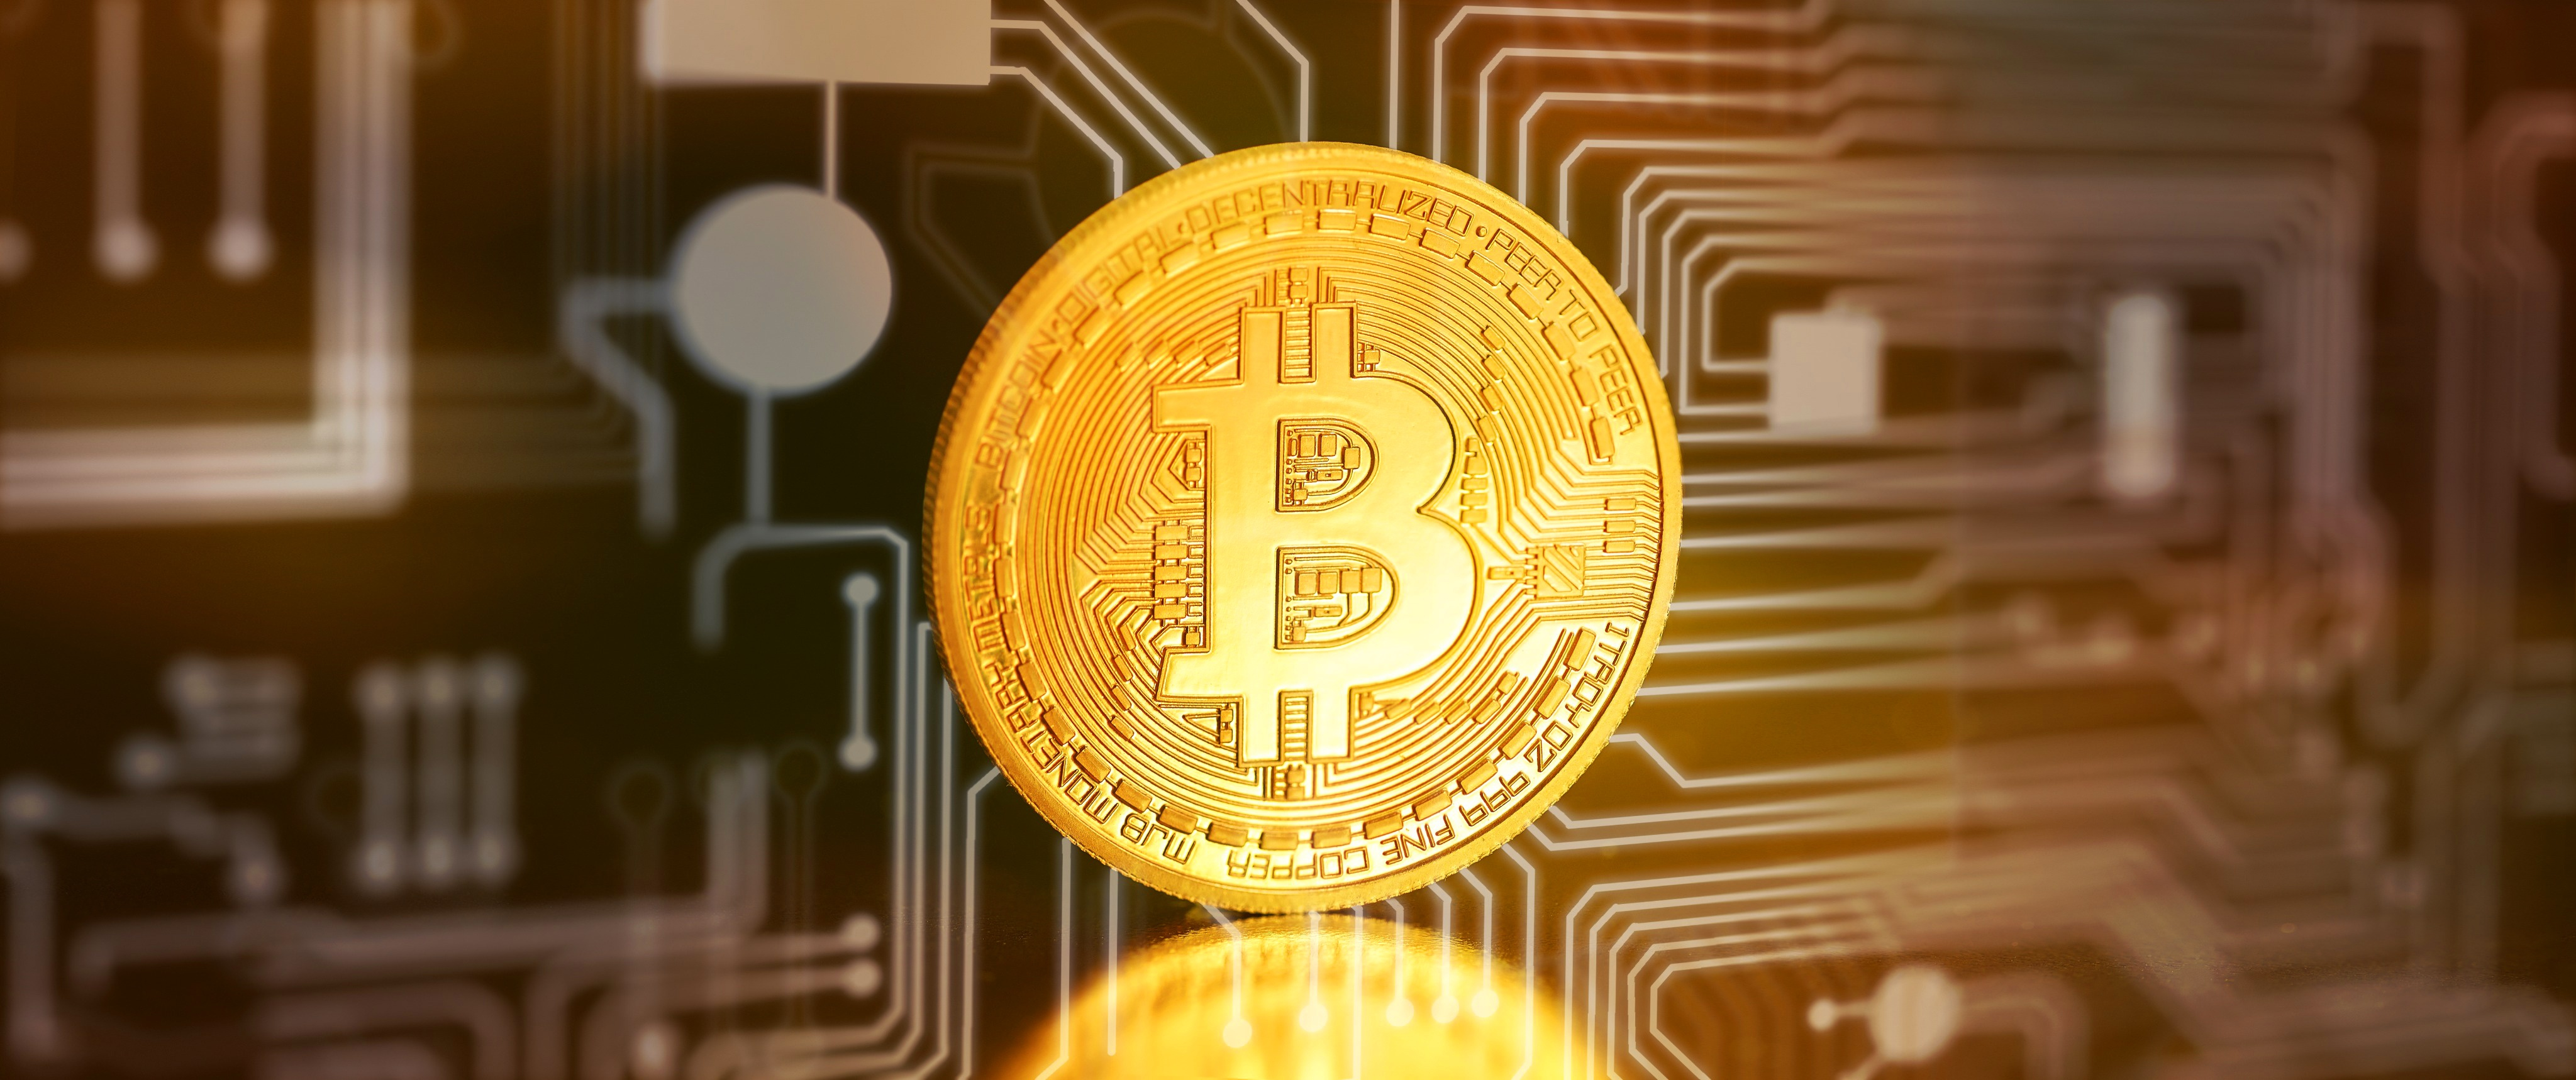

# 📊Bitcoin Price Prediction📈 using Time-Series

Bitcoin is a cryptocurrency that was created in January 2009. It is the world’s most valuable cryptocurrency and is traded on over 40 exchanges around the world, accepting over 30 different currencies. As a currency, Bitcoin offers a new opportunity for price forecasting as it has high volatility, which is much higher compared to traditional currencies.Bitcoin uses peer-to-peer technology to facilitate instant payments. Miners are responsible for processing transactions on the blockchain and are driven by repo fees.

- Timespan: Jan 2015 - Sep 2023<br>
- Data is available on basis of each day

Attribute Information:

1. Date - Each data point consist of per day
2. price - Bitcoin price in $
3. total_volume - Total bitcoins available
4. market_cap -Market value

### **Objective**:
To understand if there if our data follows and trend or seasonality so we can further predict the bitcoin price ranges accordingly.

<h2>2. Reading Data</h2>
<h3> 2.1 Loading the data </h3>

The dataset is available in:
1. .csv file format

In [1]:
pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 27.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.7
    Uninstalling Werkzeug-2.3.7:
      Successfully uninstalled Werkzeug-2.3.7


In [2]:
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

import pandas as pd



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Using Pandas library to load dataset
df = pd.read_csv('/content/drive/MyDrive/BitcoinPricePrediction/bitcoin.csv',
                  engine="python",
                  error_bad_lines=False,
                  encoding='utf-8')

df=df.drop('coin_name',axis = 1)

<ipython-input-4-8e09d358455e>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/content/drive/MyDrive/BitcoinPricePrediction/bitcoin.csv',


### Create Month and Year as Seprate variable

In [5]:
df['Year']=df.date.str.split('-').str[0]
df['Month']=df.date.str.split('-').str[1]

In [6]:
df['date']=pd.to_datetime(df['date'])
df.head(2)

,date,price,total_volume,market_cap,Year,Month
0,2015-01-01,313.992,4.699936e+07,4.293958e+09,2015,01
1,2015-01-02,314.446,3.885591e+07,4.301448e+09,2015,01


### Check for missing values

In [7]:
#Let us capture all the nan values
features_nan = [feature for feature in df.columns if df[feature].isnull().sum()>=1]
print("*"*50)
for feature in features_nan:
  print("{}: {}% missing values".format(feature,np.round(df[feature].isnull().mean(),4)*100))
print("*"*50)
print("Data type of those missing nan value features:")
print(df[features_nan].dtypes)

**************************************************
market_cap: 0.03% missing values
**************************************************
Data type of those missing nan value features:
market_cap    float64
dtype: object


In [8]:
df = df.fillna(method='ffill')
df.isnull().sum()

date            0
price           0
total_volume    0
market_cap      0
Year            0
Month           0
dtype: int64

In [9]:
data =df.copy()

In [10]:
data = data.set_index('date')

## 2. Exploratory Data Analysis w.r.to Price

#### 2.1.1 Year to Date for last 3 years

- We have data till Sep 2023 so lets calculate from Jan-Sep for last 3 years

In [11]:
ytd_21 =data.loc['2021-01-01':'2021-08-31']
ytd_22 =data.loc['2022-01-01':'2022-08-31']
ytd_23 =data.loc['2023-01-01':'2023-08-31']

ytd_data = pd.concat([ytd_21, ytd_22, ytd_23], ignore_index=False)
ytd_data

#------------------------------------------------------------

import plotly.express as px
fig = px.line(ytd_data,x = ytd_data.index,y='price', title='Bitcoin price range for last 3 YTD')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [12]:
ytd_data.groupby('Year').agg(Avg_Price_YTD=('price', np.mean)).reset_index()

,Year,Avg_Price_YTD
0,2021,44364.983256
1,2022,33203.029149
2,2023,26326.495814


**Observation**:
- For YTD data from last 3 years there quite decrease in price of bitcoins continously from 2021-2023 as it follows the decreasing trend.
 **Some key Points from the given visualization**:
-  On April 16 2021 - Bitcoin price was the highest - 63.8k
-  On June 19 2022 - Bitcoin price was the lowest  -19.01k


### 2.1.2 Total to Date for last 3 years

In [13]:
TTD =data.loc['2021-01-01':]

fig = px.line(TTD, x=TTD.index, y='price', title='Bitcoin price range for last 3 TTD')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="23", step="year", stepmode="backward"),
            dict(count=2, label="22", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [14]:
TTD.groupby('Year').agg(Avg_Price_TTD=('price', np.mean)).reset_index()

,Year,Avg_Price_TTD
0,2021,47441.731201
1,2022,28296.800644
2,2023,26309.277102


**Observation**:
- For TTD data from last 3 years there is the decreasing trend.

### 2.1 Multivariate Analysis Time Series in Dash

In [15]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

app = Dash(__name__)


app.layout = html.Div([
    html.H1('Bitcoin price analysis'),
    dcc.Graph(id="time-series-chart"),
    html.H3("Select Feature:"),
    dcc.Dropdown(
        id="ticker",
        options=["price", "total_volume", "market_cap"],
        value="price",
        clearable=False,
    ),
])


@app.callback(
    Output("time-series-chart", "figure"),
    Input("ticker", "value"))
def display_time_series(ticker):
    fig = px.line(df, x='date', y=ticker)
    return fig


app.run_server(debug=True)

<IPython.core.display.Javascript object>

### Key Points
- Price : Highest (68k) Nov 2021, Lowest(172 $) Jan 2015
- Volume : Highest (179 Billion) Jan 2021 ,Lowest (26 Million) Jul 2015
- Capital : Highest (1.28 Trillion) Nov 2021 ,Lowest (2.8 Billion) Jan 2015

**Observation**:
- 2021 was a period where the Volume and Market_capital was highest and thus this is the major reason why people were maximum investing in Bitcoin.
- So those who have invested in Bitcoin 2015 with only 172 $ due to its lower market value and kept on investing would have been highly benifited in 2021 and 2022 where in that period Bitcoin price was higher.
- In 2021 there was sudden increase in Market value of 700B to 1.3T but again there is sudden decrease from 1.3T to 700B from 2022-2023,Thus decrease in Volume and Price

#### So we can say that there is linear relationship between total_volume, market capital & price

- Volume ↑ & Price ↑ = Market Value ↑
- Volume ↓ & Price ↓ = Market Value ↓





In [16]:
#Pearson
p_corr=df[['price','total_volume','market_cap']].corr(method='pearson')
p_corr

,price,total_volume,market_cap
price,1.000000,0.674868,0.999658
total_volume,0.674868,1.000000,0.672653
market_cap,0.999658,0.672653,1.000000


#### Price & Market_cap are 99% Co-rrelated with each other

### 2.4 Stationary V/S Non- Stationary

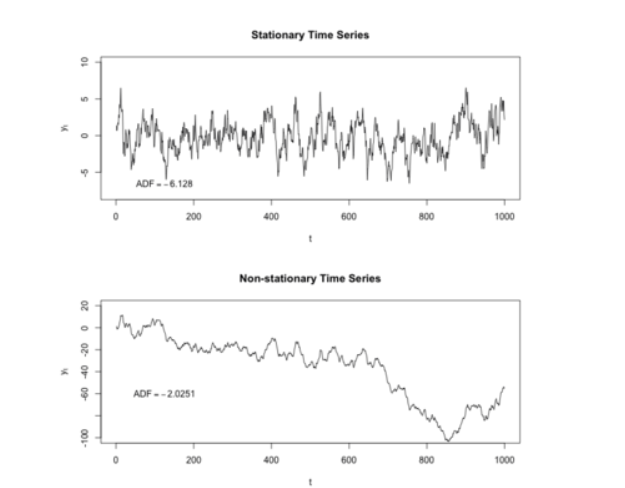

- Stationary data has Constant Mean, Constant Variance,Constant covariance between periods of identical distance
- Lets check if our data is Stationary or not ?

- Null hypothesis - Series is stationary

- Alternate hypothesis - Series is not stationary

### KPSS

In [17]:
from statsmodels.tsa.stattools import kpss

stats, p, lags, critical_values = kpss(df['price'], 'ct')

print(f'Test Statistics: {stats}')
print(f'p-value: {p}')
print(f'Critial Values: {critical_values}')

if p < 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: 0.5207978669575948
p-value: 0.01
Critial Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


<ipython-input-17-96c762b2dfae>:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




### 2.5.1 Resample Subplots from day level data to Month level

<ipython-input-18-a1646e64f94f>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



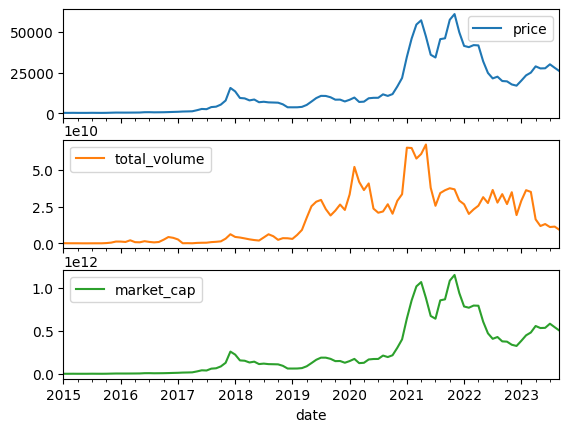

In [18]:
data.resample('M').mean().plot(subplots=True)

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

**Observation**: As Market_cap & Price are highly correlated and in given sub-plot both are almost identical

## 2.6 Summary Statistics
- Avg price overall

In [19]:
print('Overall Average Bitcoin price :',data['price'].mean())


Overall Average Bitcoin price : 14360.63861663448


### 2.7 Calculate Moving Average for Price for 7 days intervel

In [20]:
data['Pr_rolling_7'] = data['price'].rolling(window=7).mean().shift(1)


In [21]:
data_year = data[['Year','price','total_volume','market_cap','Pr_rolling_7']]

data_year=data_year.reset_index()

data_year=data_year.set_index('Year')

data_year=data_year.drop('date',axis = 1)

### 2.8 Multivariate Analysis Yearly

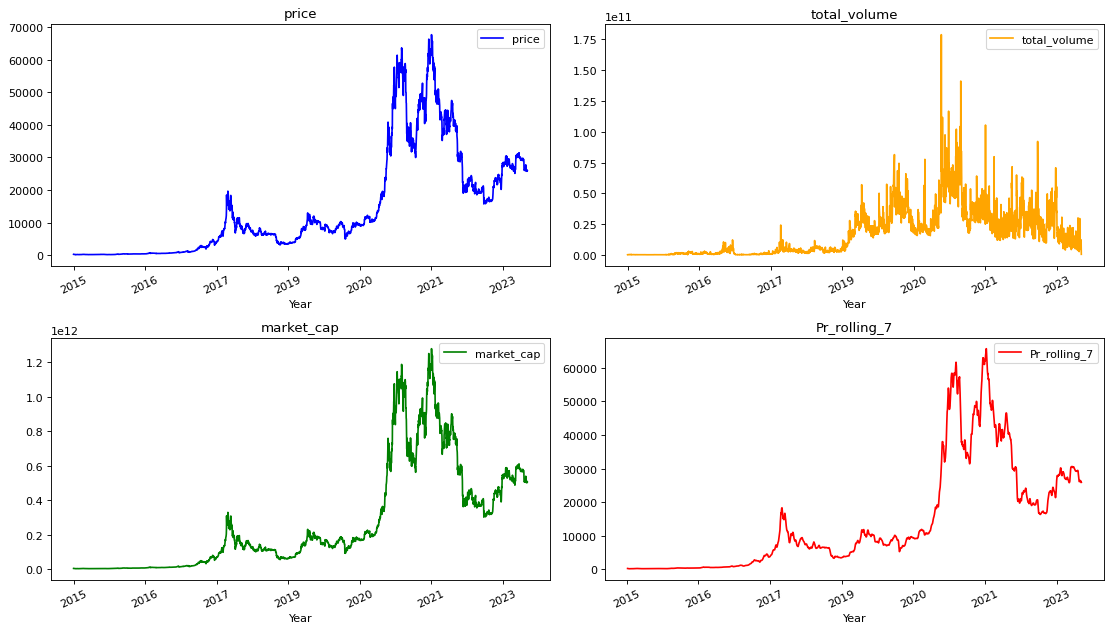

In [22]:
color_list = [
    "blue",
    "orange",
    "green",
    "red"
]


def Visualize(data):
    features= list(data_year.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(data_year)

**Observation**: Market cap, Price, Pr_rolling 7 are almost identical to each other on Yearly basis data

In [23]:
p_corr=data[['price','total_volume','market_cap','Pr_rolling_7']].corr(method='pearson')
p_corr

,price,total_volume,market_cap,Pr_rolling_7
price,1.000000,0.674868,0.999658,0.996459
total_volume,0.674868,1.000000,0.672653,0.673424
market_cap,0.999658,0.672653,1.000000,0.996319
Pr_rolling_7,0.996459,0.673424,0.996319,1.000000


- Pr_rolling_7, Market_cap, Price are highly-correlated with each other further we can only one of those feature

## 3. Find Best lag for Price feature using Vector Autoregression (VAR)

In [24]:
data = data.fillna(method='ffill')
data.isnull().sum()

price           0
total_volume    0
market_cap      0
Year            0
Month           0
Pr_rolling_7    7
dtype: int64

In [25]:
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

In [26]:
p_data = data[['price','total_volume']]

p_data.head()

train=p_data.loc['2015-01-01':'2022-12-31']
test=p_data.loc['2023-01-01':]

print(train.shape)
print(test.shape)

(2921, 2)
(253, 2)


In [27]:
model = VAR(train)
# Data is dayly basis so freq = 1D
for i in range(31):
  results = model.fit(i)
  print('Lag Order =', i)
  print('AIC: ', results.aic)
  print('BIC: ', results.bic)

Lag Order = 0
AIC:  66.07675785499781
BIC:  66.08085212497548
Lag Order = 1
AIC:  58.83794184174036
BIC:  58.85022815453885
Lag Order = 2
AIC:  58.76057864678782
BIC:  58.781061676492705
Lag Order = 3
AIC:  58.72025438660067
BIC:  58.74893881162026
Lag Order = 4
AIC:  58.69371288109324
BIC:  58.73060338416408
Lag Order = 5
AIC:  58.68989991940903
BIC:  58.735001187601355
Lag Order = 6
AIC:  58.676444047749605
BIC:  58.7297607724729
Lag Order = 7
AIC:  58.650143193556865
BIC:  58.71168007056532
Lag Order = 8
AIC:  58.649093776103605
BIC:  58.71885550550169
Lag Order = 9
AIC:  58.641015047062226
BIC:  58.719006333310176
Lag Order = 10
AIC:  58.63036435591408
BIC:  58.71658990783346
Lag Order = 11
AIC:  58.629171306021725
BIC:  58.72363583680097
Lag Order = 12
AIC:  58.63010885584616
BIC:  58.73281708304614


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Lag Order = 13
AIC:  58.61890126714091
BIC:  58.729857912700496
Lag Order = 14
AIC:  58.616096870099106
BIC:  58.73530666034073
Lag Order = 15
AIC:  58.610425882028686
BIC:  58.73789354766395
Lag Order = 16
AIC:  58.612101912270724
BIC:  58.747832188405965
Lag Order = 17
AIC:  58.60983890736192
BIC:  58.753836533503836
Lag Order = 18
AIC:  58.61188842387069
BIC:  58.764158143931944
Lag Order = 19
AIC:  58.61083283767499
BIC:  58.77137939997983
Lag Order = 20
AIC:  58.60907122739015
BIC:  58.77789938468004
Lag Order = 21
AIC:  58.6001041176717
BIC:  58.77721862711094
Lag Order = 22
AIC:  58.60297890499054
BIC:  58.78838452817197
Lag Order = 23
AIC:  58.60603853374025
BIC:  58.79974003669083
Lag Order = 24
AIC:  58.599154773687964
BIC:  58.8011569268745
Lag Order = 25
AIC:  58.59717919435147
BIC:  58.80748677268626
Lag Order = 26
AIC:  58.58976469259059
BIC:  58.808382475437135
Lag Order = 27
AIC:  58.592819454845646
BIC:  58.81975222602431
Lag Order = 28
AIC:  58.586350709965245
BIC:  5

In [28]:
model.select_order(31).summary()

,AIC,BIC,FPE,HQIC
0,66.09,66.09,5.038e+28,66.09
1,58.86,58.87,3.647e+25,58.86
2,58.78,58.80,3.373e+25,58.79
3,58.74,58.77,3.238e+25,58.75
4,58.71,58.75,3.151e+25,58.73
5,58.71,58.75,3.137e+25,58.72
6,58.69,58.75,3.093e+25,58.71
7,58.67,58.73*,3.011e+25,58.69
8,58.67,58.74,3.006e+25,58.69
9,58.66,58.73,2.979e+25,58.68


**Note**: Lag 7 is the best with lowest BIC as * means minimum

In [29]:
model = VAR(train)
results = model.fit(7)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [30]:
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Sep, 2023
Time:                     15:32:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    58.7117
Nobs:                     2914.00    HQIC:                   58.6723
Log likelihood:          -93692.8    FPE:                2.96097e+25
AIC:                      58.6501    Det(Omega_mle):     2.93072e+25
--------------------------------------------------------------------
Results for equation price
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  17.676815        20.556751            0.860           0.390
L1.price                0.974670         0.018580           52.458           0.000
L1.total_volume        -0.000000         0.000000   

In [31]:
lag=results.k_ar

out=results.forecast(train.values[-lag:],steps=5)
# steps = 7 show predictions for 7 days
print("Predicted price with Lag = 7")
out[:,:1]

Predicted price with Lag = 7


array([[16593.4135855 ],
       [16600.0858887 ],
       [16595.43183423],
       [16572.97961811],
       [16589.56342995]])

In [32]:
print("Test data:")
test['price'][0:5]

Test data:


date
2023-01-01    16540.693625
2023-01-02    16615.969318
2023-01-03    16674.342536
2023-01-04    16677.646186
2023-01-05    16855.174739
Name: price, dtype: float64

- So basically Lag = 7 performed good but not best

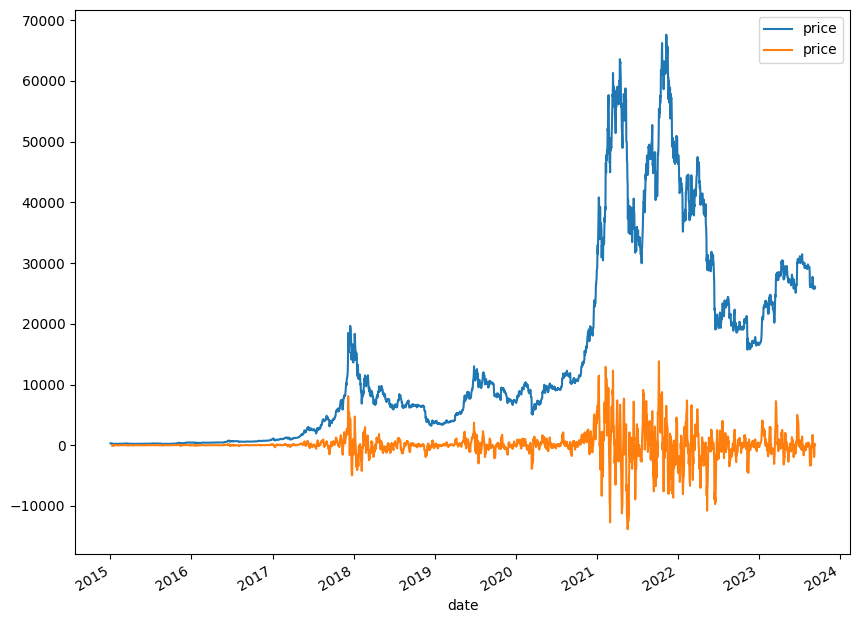

In [33]:
pd.concat([data['price'], data['price'].diff(7)],axis=1).plot()
mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['axes.grid'] = False

In [34]:
final_data=data.copy()
final_data['price_lag']=data[['price']].shift(7)

# final_data.drop('lagprice',axis =1,inplace = True)

In [35]:
final_data.head(8)

,price,total_volume,market_cap,Year,Month,Pr_rolling_7,price_lag
date,,,,,,,
2015-01-01,313.9920,4.699936e+07,4.293958e+09,2015,01,NaN,NaN
2015-01-02,314.4460,3.885591e+07,4.301448e+09,2015,01,NaN,NaN
2015-01-03,286.5720,1.187789e+08,3.921358e+09,2015,01,NaN,NaN
2015-01-04,260.9360,2.055001e+08,3.571640e+09,2015,01,NaN,NaN
2015-01-05,273.2200,1.550381e+08,3.740880e+09,2015,01,NaN,NaN
2015-01-06,285.3738,9.700290e+07,3.908408e+09,2015,01,NaN,NaN
2015-01-07,295.8725,1.106742e+08,4.053239e+09,2015,01,NaN,NaN
2015-01-08,284.4525,8.657054e+07,3.897824e+09,2015,01,290.0589,313.992


In [36]:
p_corr=final_data[['price','total_volume','market_cap','Pr_rolling_7','price_lag']].corr(method='pearson')
p_corr

,price,total_volume,market_cap,Pr_rolling_7,price_lag
price,1.000000,0.674868,0.999658,0.996459,0.991157
total_volume,0.674868,1.000000,0.672653,0.673424,0.668967
market_cap,0.999658,0.672653,1.000000,0.996319,0.991164
Pr_rolling_7,0.996459,0.673424,0.996319,1.000000,0.997726
price_lag,0.991157,0.668967,0.991164,0.997726,1.000000


# 4.1 Base model Auto Arima

In [37]:
!pip install pmdarima

import pmdarima as pm

model = pm.auto_arima(final_data['price'],
                         seasonal=False,
                       max_order=4,error_action='ignore',
                           suppress_warnings=True,
                      stepwise=True, trace=True)

#max_order=4 try 4 combination of pdq
#pdq means : p = AR parameter in Arima, High parameter given by d i.e. diffrence we want to take to make time series stationary, q = moving average parameter
# in short : P=2 i.e. AR = 2 , d = 1 i.e. diff =1 , q=2 i.e. moving average = 2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.5 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51393.348, Time=8.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51409.963, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51410.169, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51410.167, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51408.288, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=51411.569, Time=3.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=51414.159, Time=1.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=51395.418, Time=16.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=51395.352, Time=13.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51412.167, Time=3.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=51411.288, Time=4.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=51411.632, Time=3.01 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=51397.220, Time=13.01 sec
 ARI

In [38]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3174
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -25690.848
Date:                Thu, 21 Sep 2023   AIC                          51391.695
Time:                        15:34:14   BIC                          51422.008
Sample:                             0   HQIC                         51402.568
                               - 3174                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8192      0.009     89.443      0.000       0.801       0.837
ar.L2         -0.9536      0.009   -109.535      0.000      -0.971      -0.937
ma.L1         -0.8455      0.009    -94.273      0.000      -0.863      -0.828
ma.L2          0.9618      0.008    113.396      0.000       0.945       0.978
sigma2      6.368e+05   5508.377    115.600      0.000    6.26e+05    6.48e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             33143.18
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             236.51   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
train=final_data[(final_data.index.get_level_values(0) >= '2015-01-01') & (final_data.index.get_level_values(0) < '2023-01-01')]
test=final_data[(final_data.index.get_level_values(0) >= '2023-01-01')]

In [40]:
model.fit(train['price'])

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [41]:
forecast = model.predict(n_periods=7, return_conf_int=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [42]:
forecast[0]

2921    16570.420803
2922    16512.252271
2923    16496.463365
2924    16538.615501
2925    16588.057795
2926    16588.608673
2927    16542.248789
dtype: float64

In [43]:
test['price'].head(7)

date
2023-01-01    16540.693625
2023-01-02    16615.969318
2023-01-03    16674.342536
2023-01-04    16677.646186
2023-01-05    16855.174739
2023-01-06    16832.098988
2023-01-07    16960.232062
Name: price, dtype: float64

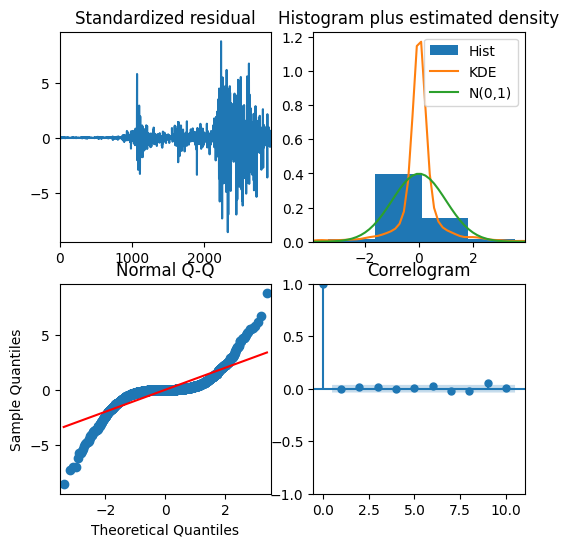

In [44]:
out=model.plot_diagnostics()
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.grid'] = False

**Overal Observation**
- 1: Due to very less bitcoin price around 150 to  300$ at beginning to 60 to 70k there we can see outliers.
- Also Auto Arima did not perfomed much better because in real world prices get flucuates very high or low day by day but Arima perfomed normal operation by normally increasing or decreasing price range which gives us base prediction but not generalised results.
- We have to look for some other time-series function in this case to get generalised results

# 5. Auto Time-series to select best Model

In [45]:
!pip install auto-ts --no-deps --ignore-installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 2.7 MB/s eta 0:00:00


In [46]:
!pip install 'fsspec>=0.3.3'

In [47]:
!pip install statsmodels --upgrade

In [48]:
!pip install tscv

In [49]:
from auto_ts import auto_timeseries

Imported auto_timeseries version:0.0.71. Call by using:
model = auto_timeseries(score_type='rmse',
        time_interval='M', non_seasonal_pdq=None, seasonality=False,
        seasonal_period=12, model_type=['best'], verbose=2, dask_xgboost_flag=0)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



In [50]:
model = auto_timeseries(score_type='rmse', time_interval='D', seasonality=False, model_type=['best'], verbose=2)

# score_type = 'mae' = mean absolute error
#time_interval = 'd' , if data is on month basis then 'm' if data is in day level then 'D'
# pdq means : p = AR parameter in Arima, High parameter given by d i.e. diffrence we want to take to make time series stationary, q = moving average parameter
# in short : P=2 i.e. AR = 2 , d = 1 i.e. diff =1 , q=2 i.e. moving average = 2
# if our data is not following seasonlity then keep seasonality=False
# model_type=['best'] it will run all models

https://github.com/AutoViML/Auto_TS

### Train Test Split

In [51]:
train=df[(df['date'] >= '2015-01-01') & (df['date'] <= '2022-12-31')]
test=df[(df['date'] >= '2023-01-01')]

Start of Fit.....
    Target variable given as = price
Start of loading of data.....
    Inputs: ts_column = date, sep = ,, target = ['price']
    Using given input: pandas dataframe...
    date column exists in given train data...
    train data shape = (2921, 2)
Alert: Could not detect strf_time_format of date. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is stationary after one differencing
There is 1 differencing needed in this datasets for VAR model


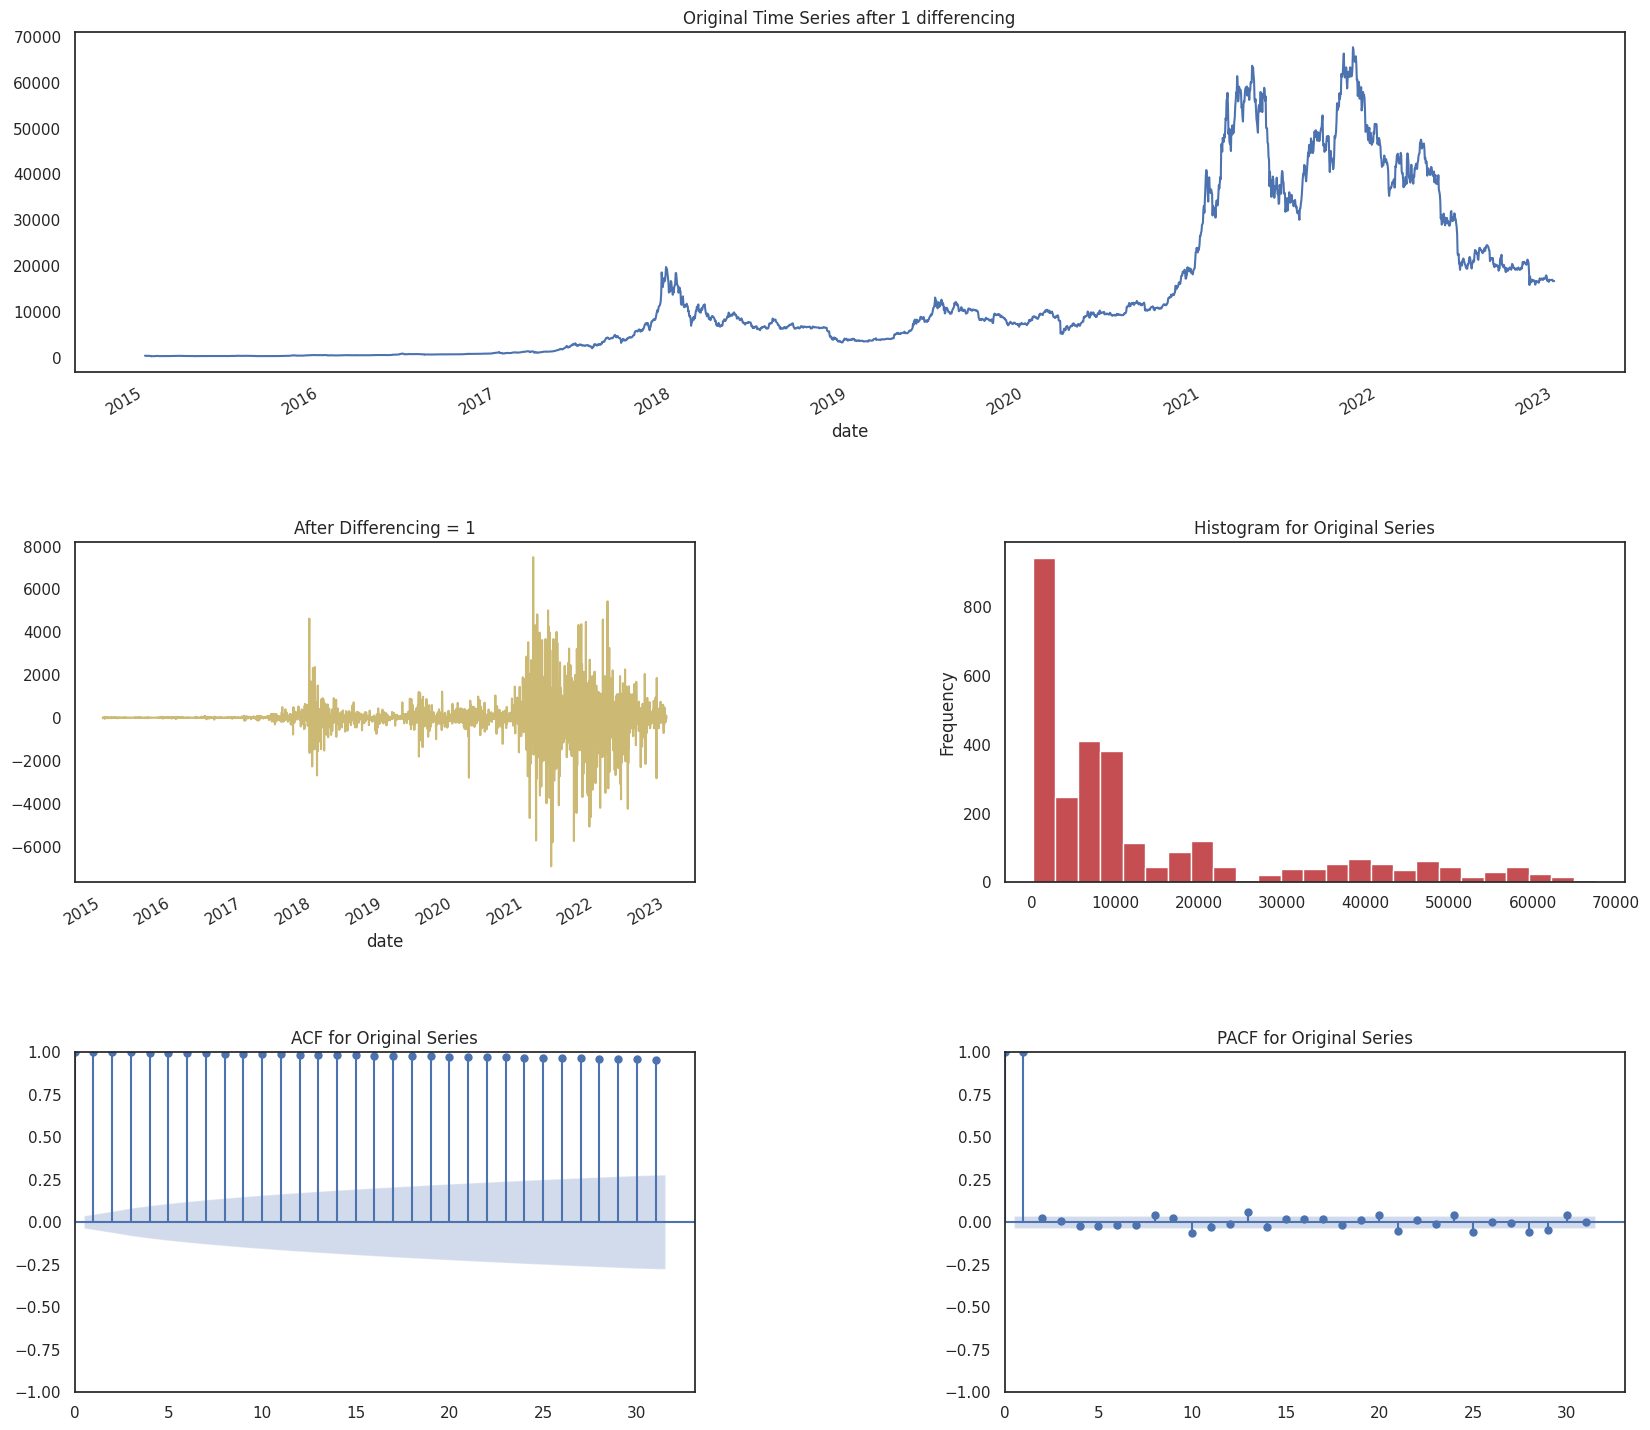

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6drs72ia/nbgu4vrw.json


Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(2921, 3)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 3

Fold Number: 1 --> Train Shape: 2906 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6drs72ia/4_l4rpgg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39432', 'data', 'file=/tmp/tmp6drs72ia/nbgu4vrw.json', 'init=/tmp/tmp6drs72ia/4_l4rpgg.json', 'output', 'file=/tmp/tmp6drs72ia/prophet_model26jp2tka/prophet_model-20230921153439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
15:34:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6drs72ia/8q44a2d0.json


    RMSE = 8,804.95
    Std Deviation of actuals = 164.73
    Normalized RMSE (as pct of std dev) = 5345%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 2911 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6drs72ia/0bamk6wk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34100', 'data', 'file=/tmp/tmp6drs72ia/8q44a2d0.json', 'init=/tmp/tmp6drs72ia/0bamk6wk.json', 'output', 'file=/tmp/tmp6drs72ia/prophet_model3jjg2_o6/prophet_model-20230921153440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
15:34:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6drs72ia/pav7lmrh.json


    RMSE = 6,875.59
    Std Deviation of actuals = 20.21
    Normalized RMSE (as pct of std dev) = 34023%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 2916 Test Shape: 5


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6drs72ia/y15vszux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72741', 'data', 'file=/tmp/tmp6drs72ia/pav7lmrh.json', 'init=/tmp/tmp6drs72ia/y15vszux.json', 'output', 'file=/tmp/tmp6drs72ia/prophet_modell0585721/prophet_model-20230921153441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
15:34:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    RMSE = 9,126.49
    Std Deviation of actuals = 123.16
    Normalized RMSE (as pct of std dev) = 7410%
Cross Validation window: 3 completed

-------------------------------------------


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6drs72ia/1yruhxhn.json


Model Cross Validation Results:
-------------------------------------------
    MAE (Mean Absolute Error = 8267.37
    MSE (Mean Squared Error = 69364576.47
    MAPE (Mean Absolute Percent Error) = 49%
    RMSE (Root Mean Squared Error) = 8328.5399
    Normalized RMSE (MinMax) = 1744%
    Normalized RMSE (as Std Dev of Actuals)= 5925%
Time Taken = 4 seconds


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6drs72ia/v4nzl5v3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26190', 'data', 'file=/tmp/tmp6drs72ia/1yruhxhn.json', 'init=/tmp/tmp6drs72ia/v4nzl5v3.json', 'output', 'file=/tmp/tmp6drs72ia/prophet_modelu35op14c/prophet_model-20230921153442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=100']
15:34:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  End of Prophet Fit


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 2906 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(0,1,0)*(0,0,0,12), aic = 47188.471
Static Forecasts:
    RMSE = 660.25
    Std Deviation of Actuals = 164.73
    Normalized RMSE (as pct of std dev) = 400.8%

Fold Number: 2 --> Train Shape: 2911 Test Shape: 5

    Finding the best parameters using AutoArima:
    Using smaller parameters for larger dataset with greater than 1000 samples

Best model is a Seasonal SARIMAX(0,1,0)*(0,0,0,12), aic = 47266.053
Static Forecasts:
    RMSE = 77.25
    Std Deviation of Actuals = 20.21
    Normalized RMSE (as pct of std dev) = 382.3%

Fold Number: 3 --> Train Shape: 2916 Test Shape: 5

    Findi

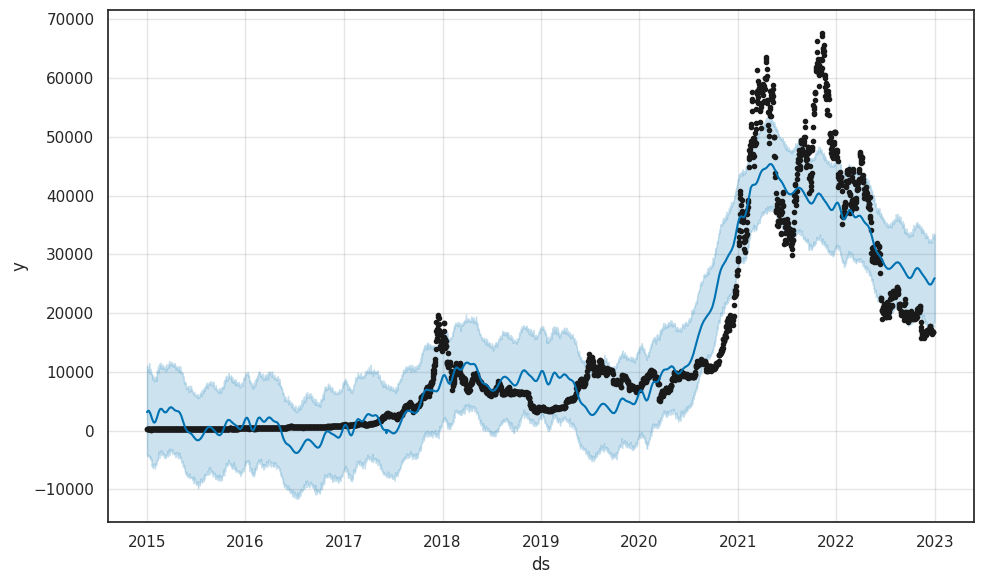

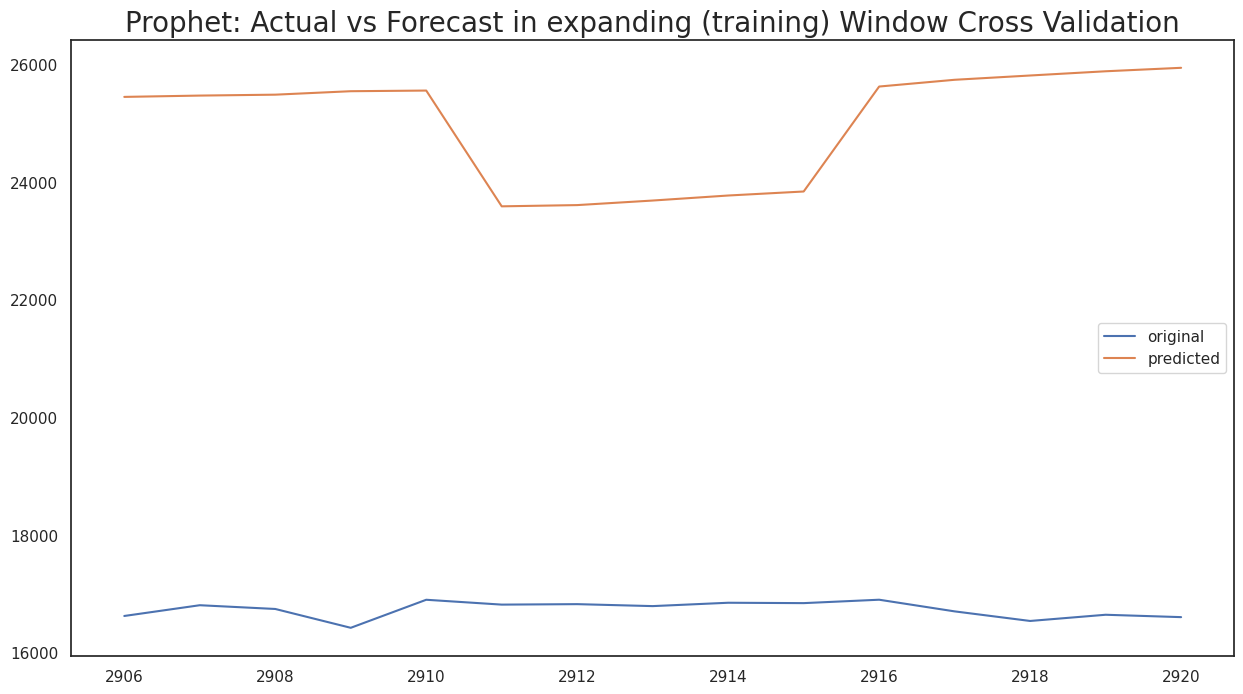

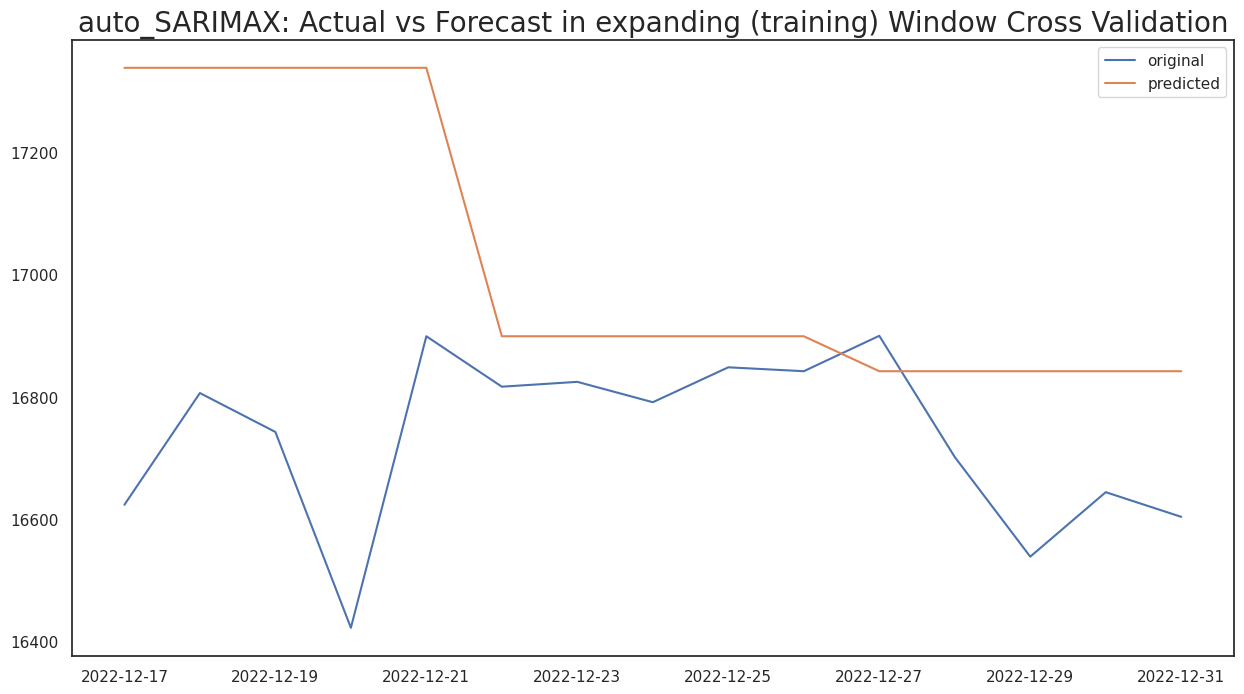

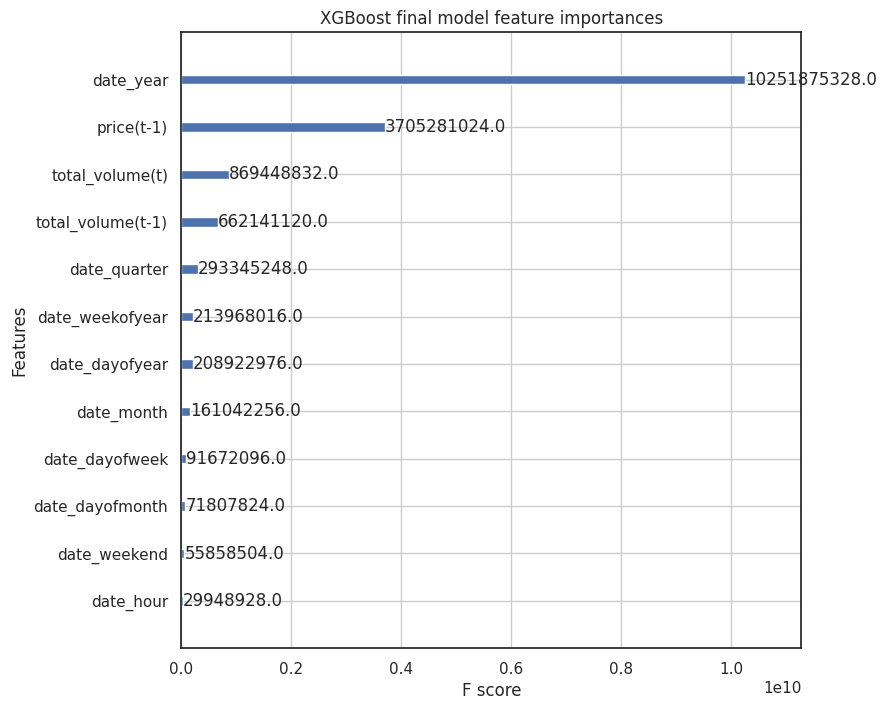

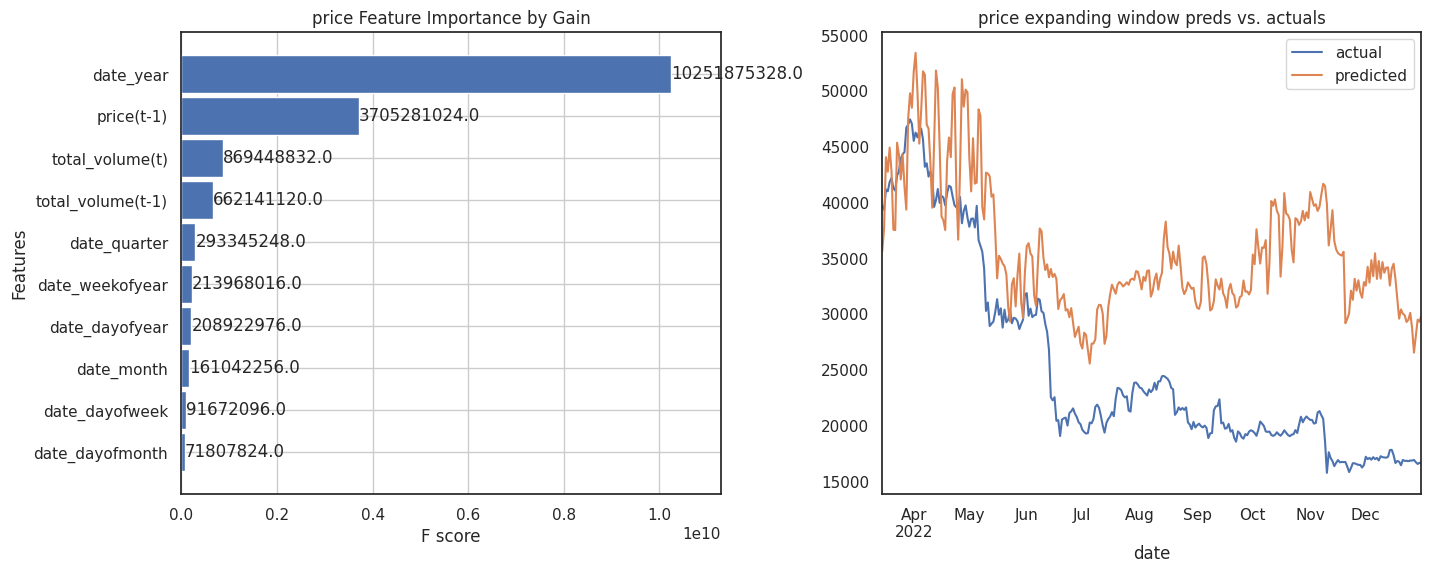

In [52]:
model.fit(traindata=train[['date','price','total_volume']], ts_column='date', target='price', cv=3)

mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.grid'] = False
# take those col which required
# ts_col = 'timestamp i.e. which col should be our timestamp column
# target = output var to predict
# cv = 3 i.e. cross validation

In [53]:
model.get_leaderboard()

,name,rmse
1,auto_SARIMAX,314.286938
0,Prophet,8269.010780
2,ML,12142.480709


- auto_SARIMAX has the less RMSE from all 3 models

In [54]:
model.get_cv_scores()

,Model,CV Scores
0,Prophet,8804.946523
1,Prophet,6875.593906
2,Prophet,9126.491910
3,auto_SARIMAX,660.248079
4,auto_SARIMAX,77.252943
5,auto_SARIMAX,205.359791
6,ML,12142.480709


In [55]:
results_dict = model.get_ml_dict()

results_dict['auto_SARIMAX']['forecast']



[array([17338.35812663, 17338.35812663, 17338.35812663, 17338.35812663,
        17338.35812663]),
 array([16899.33196905, 16899.33196905, 16899.33196905, 16899.33196905,
        16899.33196905]),
 array([16842.17703991, 16842.17703991, 16842.17703991, 16842.17703991,
        16842.17703991])]

In [56]:

future_predictions = model.predict(testdata=test[['date','price','total_volume']], model='auto_SARIMAX')
future_predictions[['yhat']].head(7)

Predicting using test dataframe as input for auto_SARIMAX model


price,yhat
2921,16619.599354
2922,16623.219714
2923,16606.956051
2924,16593.906498
2925,16569.424763
2926,16586.553289
2927,16566.962016


In [57]:
test.head(7)

,date,price,total_volume,market_cap,Year,Month
2921,2023-01-01,16540.693625,1.201325e+10,3.182783e+11,2023,01
2922,2023-01-02,16615.969318,9.799253e+09,3.198320e+11,2023,01
2923,2023-01-03,16674.342536,1.302386e+10,3.214865e+11,2023,01
2924,2023-01-04,16677.646186,1.536717e+10,3.210808e+11,2023,01
2925,2023-01-05,16855.174739,2.083656e+10,3.243976e+11,2023,01
2926,2023-01-06,16832.098988,1.491904e+10,3.241390e+11,2023,01
2927,2023-01-07,16960.232062,1.904658e+10,3.265714e+11,2023,01


- Main reason our models are not performing that great because it is not able to understand the trend/pattern in sudden change in bitcoin price ranges so in this case we can try some other techniques to improve our models

### 8.2 Convert non-stationary data into stationary with Differencing

In [58]:
from statsmodels.tsa.stattools import kpss

stats, p, lags, critical_values = kpss(data['price'], 'ct')

print(f'Test Statistics: {stats}')
print(f'p-value: {p}')
print(f'Critial Values: {critical_values}')

if p < 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: 0.5207978669575948
p-value: 0.01
Critial Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


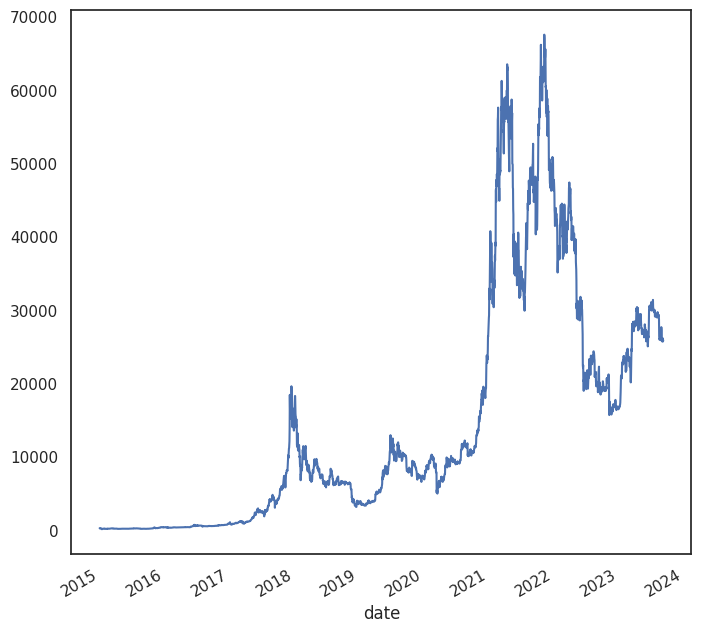

In [59]:
data.price.plot()

mpl.rcParams['figure.figsize'] = (4,4)
mpl.rcParams['axes.grid'] = False

In [60]:
pm.arima.ndiffs(data['price'],alpha=0.05,test='kpss',max_d = 4)

1

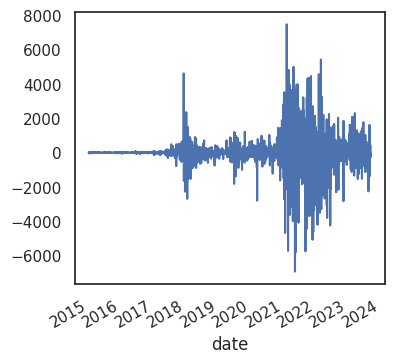

In [61]:
lag_p = data['price'].rolling(window = 2).apply(lambda x:x.iloc[1]-x.iloc[0]).dropna()
lag_p.plot()

mpl.rcParams['figure.figsize'] = (4,4)
mpl.rcParams['axes.grid'] = False

In [62]:
pm.arima.ndiffs(lag_p,alpha=0.05,test='kpss',max_d = 4)

0

In [63]:
from statsmodels.tsa.stattools import kpss

stats, p, lags, critical_values = kpss(lag_p, 'ct')

print(f'Test Statistics: {stats}')
print(f'p-value: {p}')
print(f'Critial Values: {critical_values}')

if p < 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: 0.06571482223552208
p-value: 0.1
Critial Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is Stationary


In [64]:
# type(lag_p)
data1 = pd.DataFrame(lag_p)

data['price_stat'] = data1['price']




In [65]:
data.head(7)

,price,total_volume,market_cap,Year,Month,Pr_rolling_7,price_stat
date,,,,,,,
2015-01-01,313.9920,4.699936e+07,4.293958e+09,2015,01,NaN,NaN
2015-01-02,314.4460,3.885591e+07,4.301448e+09,2015,01,NaN,0.4540
2015-01-03,286.5720,1.187789e+08,3.921358e+09,2015,01,NaN,-27.8740
2015-01-04,260.9360,2.055001e+08,3.571640e+09,2015,01,NaN,-25.6360
2015-01-05,273.2200,1.550381e+08,3.740880e+09,2015,01,NaN,12.2840
2015-01-06,285.3738,9.700290e+07,3.908408e+09,2015,01,NaN,12.1538
2015-01-07,295.8725,1.106742e+08,4.053239e+09,2015,01,NaN,10.4987


- Note: Price cannot be -ve, this is invalid

# 8.1 Apply Deep Learning Models

## 8.2 LSTM

In [66]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

### Min Max Scaler

In [67]:
data.columns

Index(['price', 'total_volume', 'market_cap', 'Year', 'Month', 'Pr_rolling_7',
       'price_stat'],
      dtype='object')

In [69]:
data_input = data[['price', 'total_volume']]

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_input)

data_scaled

array([[2.10311184e-03, 1.60787058e-04],
       [2.10984327e-03, 1.15261299e-04],
       [1.69655756e-03, 5.62068647e-04],
       ...,
       [3.85799342e-01, 2.51781324e-02],
       [3.81572107e-01, 4.49504883e-02],
       [3.81306658e-01, 2.16109682e-03]])

In [70]:
features=data_scaled
# input var
target=data_scaled[:,0]
#output var

In [71]:
TimeseriesGenerator(features, target, length=7, sampling_rate=1, batch_size=1)[0]
# We are giving length = 7 i.e. 7 day wimdow
# predict price i.e. target variable for 8th day

(array([[[0.00210311, 0.00016079],
         [0.00210984, 0.00011526],
         [0.00169656, 0.00056207],
         [0.00131645, 0.00104688],
         [0.00149859, 0.00076477],
         [0.00167879, 0.00044033],
         [0.00183446, 0.00051676]]]),
 array([0.00166513]))

- array([0.00166513]) is output predicted using 7 rows as input

In [72]:
data_scaled[7] #orignal value

array([0.00166513, 0.00038201])

### Train Test Split

In [73]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle = False)
# Shuffule = False is imp in time-series because it in time order we dont want to shuffle random

In [74]:
print(x_train.shape)

print(x_test.shape)

(2539, 2)
(635, 2)


### Define Time-series generator

In [112]:
win_length=30
# Last time we did window for 7 days
# Now we will set length for 30 days to see if there is any pattern after every 30 days

batch_size=32
num_features=2
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

# 9.1 Define LSTM Model

In [113]:
model = tf.keras.Sequential() #sequentail layer
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
# LSTM LAYER = 128
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
# Act func = LeakyRelu
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
# LSTM LAYER 2 = 128
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [114]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30, 128)           67072     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 128)           131584    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 dropout_6 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [115]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')
# early_stopping =  We are giving 50 epochs but if our validation loss is not imporoving even at 2 iterations then stop
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/50
79/79 [==============================] - 8s 33ms/step - loss: 0.0184 - mean_absolute_error: 0.0670 - val_loss: 0.0077 - val_mean_absolute_error: 0.0689
Epoch 2/50
79/79 [==============================] - 1s 16ms/step - loss: 0.0161 - mean_absolute_error: 0.0812 - val_loss: 0.0073 - val_mean_absolute_error: 0.0740
Epoch 3/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0055 - mean_absolute_error: 0.0485 - val_loss: 0.0062 - val_mean_absolute_error: 0.0698
Epoch 4/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_absolute_error: 0.0381 - val_loss: 0.0063 - val_mean_absolute_error: 0.0718
Epoch 5/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0032 - mean_absolute_error: 0.0357 - val_loss: 0.0054 - val_mean_absolute_error: 0.0664
Epoch 6/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0033 - mean_absolute_error: 0.0378 - val_loss: 0.0026 - val_mean_absolute_error: 0.0426
Epoch 7/50
79/79 [====

In [116]:
model.evaluate_generator(test_generator, verbose=0)
# mae for 30 days= 0.065
# mae for 15 days = 0.181

[0.004345645662397146, 0.05925028771162033]

In [117]:
predictions=model.predict_generator(test_generator)

In [118]:
print(data.shape)
print(predictions.shape) # it took 30 rows as 1 as 15 days as 1 length so it got reduced to 605

(3174, 7)
(605, 1)


In [119]:
 data_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

### 9.3 Inverse Scaling to get to orignal form

In [120]:
rev_trans=scaler.inverse_transform(data_pred)
rev_trans

array([[4.75479052e+04, 4.39057459e+10],
       [4.72357220e+04, 2.02383144e+10],
       [4.69945324e+04, 1.46510086e+10],
       ...,
       [2.94960869e+04, 4.52199778e+09],
       [2.94077648e+04, 8.05879434e+09],
       [2.93243975e+04, 4.04806433e+08]])

In [121]:
data_final=data_input[predictions.shape[0]*-1:]
data_final.count()

price           605
total_volume    605
dtype: int64

In [122]:
data_final['Price_Pred']=rev_trans[:,0]

data_final

,price,total_volume,Price_Pred
date,,,
2022-01-14,42608.410012,4.390575e+10,47547.905227
2022-01-15,43120.854511,2.023831e+10,47235.721961
2022-01-16,43226.650270,1.465101e+10,46994.532378
2022-01-17,43119.792143,1.445235e+10,46806.073495
2022-01-18,42298.341117,1.769493e+10,46655.587790
...,...,...,...
2023-09-06,25784.413520,7.633736e+09,29664.192342
2023-09-07,25752.958419,1.222543e+10,29584.380728
2023-09-08,26192.333433,4.521998e+09,29496.086857


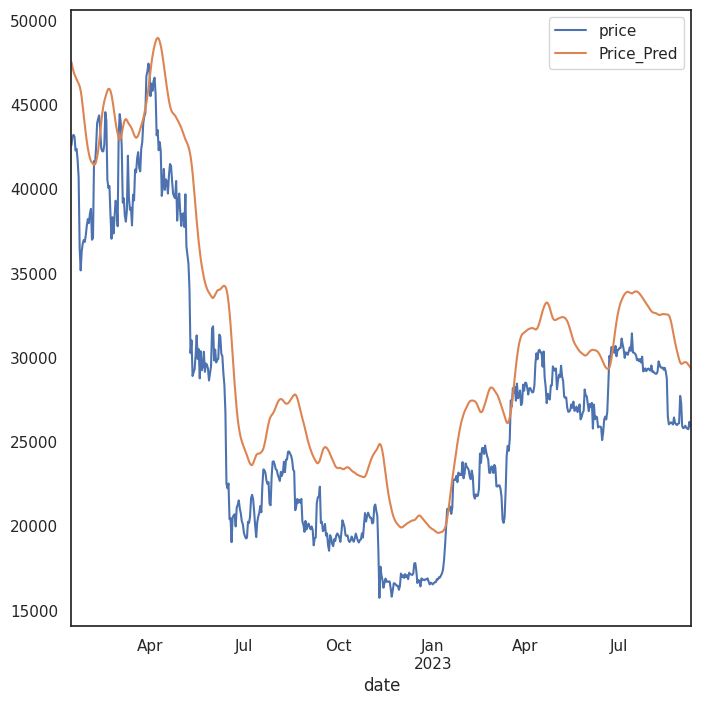

In [124]:
data_final[['price','Price_Pred']].plot()

mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.grid'] = False

### Observation:
- We performed Min Max scaling in order to scale it between 0-1 instead of standard-scaling
- We have tried 30 days window length for prediction and calculated it MAE.
- After running it for some epoch we got best results from model.
- Then we again rescaled the features to its orignal form tu understand it more better.
- Finally we have got best results which does not give us exact but near to actual values and also we see the graph it follows the same patter as actual price range which help us to predict pattern in future as well, so we can conclude that after using n number of models and window length, LSTM model with 30 days of window help us to understand the price range per month with less error


### Conclusion

- So after loading the bitcoin time series day level data we have started EDA process on looking for last 3 years YTD(Year to Date) and TTD (Total to Date) analysis to understand the bitcoin price ranges as in 2021,2022,2023 bitcoin became popular and there was huge demand so we tried to look a trend/pattern to understand our data well. Also tried to check if data is Stationary or Non- stationary.

### Models used
- Auto Arima .
- Auti Time series using multiple models
- LSTM

### Modelling Task
- Finally after trying multiple time series models we have applied LSTM with scaling our data with min max scaler by using window length for (7,15,25,30) multiple days to see if there is any pattern by running it for diffrent iterations.After running it for diffrent window length we got best MAE = 0.0592 for 30 day window which gave us almost nearby price prediction.
- So we can say that with 30 day range our model can understand the pattern of price range in bitcoin in future as well

